In [1]:
import torch, torchvision
import albumentations as A
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import pandas as pd
from tensorboardX import SummaryWriter
from torch.utils.data import DataLoader

In [2]:
plt.rcParams['figure.figsize'] = (12,12)

# Load dataset

In [3]:
from sklearn.model_selection import train_test_split

image_dir, point_dir = 'images', 'points'
names = [f[:-4] for f in os.listdir(image_dir)]

train_set, test_set = train_test_split(names, test_size=0.2)
val_set, test_set = train_test_split(test_set, test_size=0.95)

print( len(train_set),len(test_set), len(val_set) )

3253 774 40


In [4]:
from utils import add_points

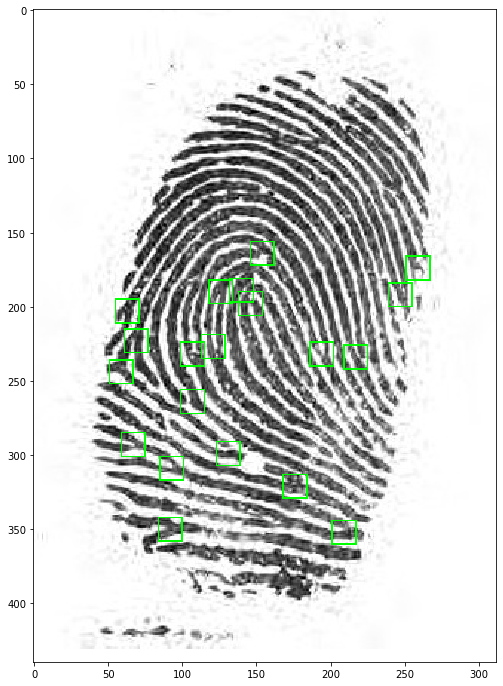

In [26]:
i = 1
image = cv2.imread(os.path.join(image_dir,train_set[i]+'.jpg'))/255.
points =  pd.read_csv(os.path.join(point_dir,train_set[i]+'.txt'), delimiter="\t").values
image = add_points(image,points, rgb_color=(0,1,0))
plt.imshow(image)
plt.show()

## Define size and $d_1$ distance

This is the size of training patches and the maximum distance at which we will look for points from the center.

In [5]:
SIZE = (53,53)
INTER_DIST = 11

## Define transformations

In [6]:
transform = A.Compose([
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5)], 
        keypoint_params = A.KeypointParams(format='xy'))

Keypoints support for Crop added in albumentations 0.4.0, so if you have an older version you need to run the code below.

In [0]:
# def apply_to_keypoint(self, keypoint,  **params):
#     crop_coords = self.x_min, self.y_min, self.x_max, self.y_max
#     return A.augmentations.functional.crop_keypoint_by_coords(keypoint, crop_coords, None,None,None,None)


# A.Crop.apply_to_keypoint = apply_to_keypoint

## Create dataloaders

In [6]:
from finger_dataset import FingerDataset

In [9]:
cache_size = 50000
finger_ds = FingerDataset(train_set, image_dir, point_dir, transform, cache_size, SIZE, INTER_DIST)
train_loader = DataLoader(finger_ds, batch_size=256, shuffle=True, num_workers=4)
train_iter = iter(train_loader)

val_ds = FingerDataset(val_set, image_dir, point_dir, transform, 5000, SIZE, INTER_DIST)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=True, num_workers=4)

test_ds = FingerDataset(test_set, image_dir, point_dir, transform, 10000, SIZE, INTER_DIST)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=4)
test_iter = iter(test_loader)

## Look at the training data

In [6]:
from utils import grid, get_coord, compute_image_relative_coord

(32, 55, 55, 3)


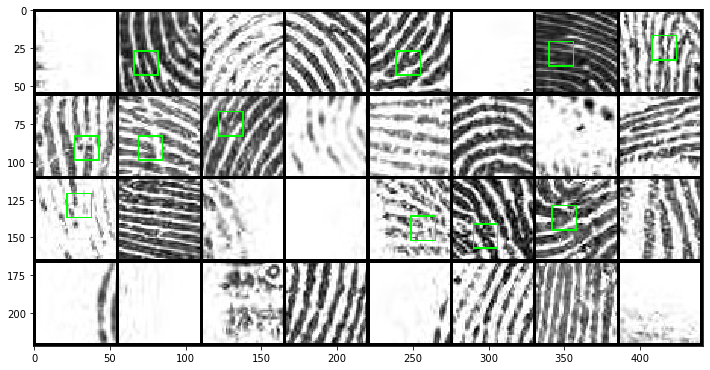

In [29]:
batch_x, batch_y  = train_iter.next()
points = get_coord(batch_y[:32,1:].numpy(), SIZE, INTER_DIST)
patches = batch_x[:32].permute(0,2,3,1)
sh = patches.shape
patches = patches.expand(sh[0],sh[1],sh[2],3).clone().cpu().numpy()
for i in range(patches.shape[0]):
    if batch_y[i,0] == 1:
        patches[i] = add_points(patches[i],[points[i]], rgb_color=(0,1,0))

plt.imshow(grid(patches))
plt.show()

## Training the model

In [7]:
from detector import YOLO, loss

model = YOLO(size=SIZE, inter_dist=INTER_DIST)

In [8]:
device = torch.device('cuda')
model = model.to(device=device)
opt = torch.optim.Adam(params=model.parameters(), lr = 0.0008)
writer = SummaryWriter("logs")

In [0]:
def metric(logits, y_target, tol=0.01):
    logits = logits.squeeze()
    pred = (logits[:,0] > 0) == y_target[:,0].to(torch.uint8)
    err = ((logits[:,1:]-y_target[:,1:])**2).sum(1) < tol
    return (pred*err).to(torch.float).mean()

In [0]:
def train(model, num_iter, train_loader, train_ds, val_loader, val_ds, opt, loss_func, metric, device, writer):
    model.train()
    train_iterator = iter(train_loader)
    val_iterator = iter(val_loader)
    print(len(train_iterator))
    for i in range(num_iter):
        try:
            batch_x, batch_y = train_iterator.next()
        except StopIteration:
            train_iterator = iter(train_loader)
            batch_x, batch_y = train_iterator.next()
        train_ds.update_cache()
        out = model(batch_x.to(device)) 
        loss = loss_func(out, batch_y.to(device))
        loss.backward()
        opt.step()
        opt.zero_grad()
        if i%10 == 0:
            writer.add_scalar('data/loss', loss, i)
        if i%100 == 0:
            model.eval()
            try:
                batch_x, batch_y = val_iterator.next()
            except StopIteration:
                val_iterator = iter(val_loader)
                batch_x, batch_y = val_iterator.next()
            with torch.no_grad():
                acc = metric(model(batch_x.to(device)), batch_y.to(device))
            writer.add_scalar('data/val_accuracy', acc, i)
            val_ds.update_cache()
            model.train()
        if i%100 == 0:
            print('iteration ' + str(i))

In [120]:
train(model, 150000, train_loader, finger_ds, val_loader, val_ds,  opt, loss, metric, device, writer)

In [28]:
torch.save(model.state_dict, '150000_dist_11.state_dict')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type YOLO. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/

## Look on predictions

In [9]:
model.load_state_dict(torch.load('150000_dist_11.state_dict')())
model.eval()

YOLO(
  (net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (16): 

In [14]:
batch_x, batch_y  = test_iter.next()
out = model(batch_x.cuda()).detach().squeeze()

(32, 55, 55, 3)


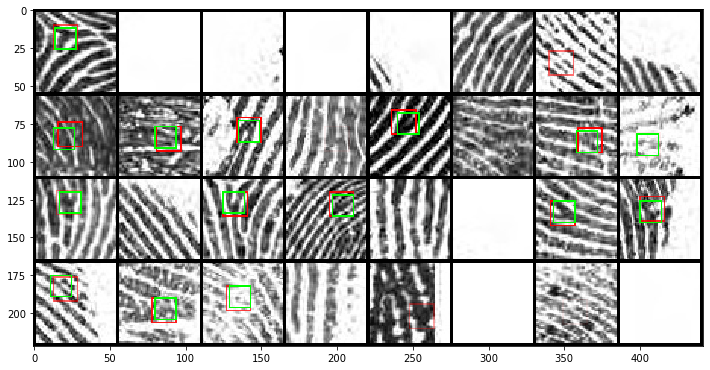

In [54]:
prob = torch.sigmoid(out[:,0])
pred_points = get_coord(out[:32,1:].cpu().numpy(), SIZE, INTER_DIST).round().astype('int')
true_points = get_coord(batch_y[:32,1:].cpu().numpy(), SIZE, INTER_DIST).round().astype('int')
patches = batch_x[:32].permute(0,2,3,1)
sh = patches.shape
patches = patches.expand(sh[0],sh[1],sh[2],3).clone().cpu().numpy()
for i in range(patches.shape[0]):
    patches[i] = add_points(patches[i],[pred_points[i]], rgb_color=(1,0,0), p=float(prob[i]), d=8)
    if batch_y[i,0] == 1:
        patches[i] = add_points(patches[i],[true_points[i]], rgb_color=(0,1,0), d=7)

plt.imshow(grid(patches))
plt.show()

## Evaluation on patches

In [42]:
# tolerance distance. prediction is considered correct if distance between target point and predicted point < tol.
tol = 5

test_iter = iter(test_loader)
target = []
pred = []
for i in range(len(test_iter)):
    batch_x, batch_y  = test_iter.next()
    out = model(batch_x.cuda()).detach().squeeze()
    prob = torch.sigmoid(out[:,0]).cpu().numpy()
    pred_points = get_coord(out[:,1:].cpu().numpy(), SIZE, INTER_DIST).round().astype('int')
    true_points = get_coord(batch_y[:,1:].cpu().numpy(), SIZE, INTER_DIST).round().astype('int')
    target.extend(batch_y[:,0].tolist())
    pred.extend(np.where(batch_y[:,0], prob*(np.abs(pred_points - true_points).sum(axis=1) <= tol), prob).tolist())

In [47]:
from sklearn.metrics import precision_recall_curve, roc_curve

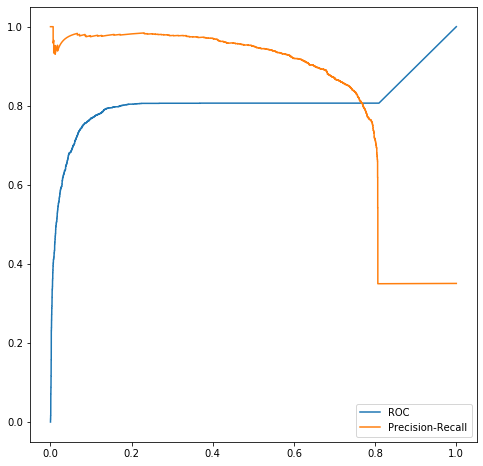

In [48]:
fpr, tpr, thresholds = roc_curve(target, pred)
precision, recall, thresholds = precision_recall_curve(target, pred)

plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label='ROC')
plt.plot(recall, precision, label='Precision-Recall')
plt.title('')
plt.legend()
plt.show()

#### Optimal threshold

In [63]:
f1_scores =  2/(1/(precision+1e-6) + 1/(recall+1e-6))
idx = f1_scores.argmax()
precision[idx], recall[idx], thresholds[idx]

(0.8347055098163395, 0.7518539646320593, 0.5137084722518921)

## Evaluation on whole images

In [64]:
threshold = 0.5
i = np.random.randint(500)
image = cv2.imread(os.path.join(image_dir,train_set[i]+'.jpg'), 2)/255.
points =  pd.read_csv(os.path.join(point_dir,train_set[i]+'.txt'), delimiter="\t").values
coord, prob = model.predict(image,threshold=threshold)

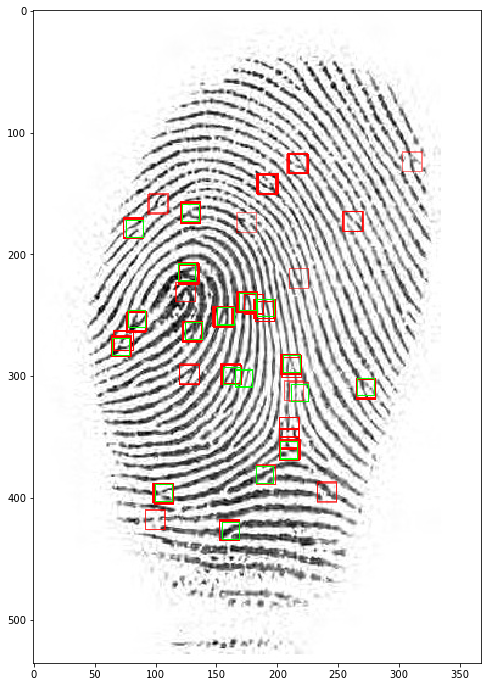

In [116]:
image = cv2.imread(os.path.join(image_dir,train_set[i]+'.jpg'))/255.
image = add_points(image,coord, p=prob, rgb_color=(1,0,0), d=8)
image = add_points(image,points, p=1, rgb_color=(0,1,0), d=7)
plt.imshow(image)
plt.show()

#### We get predictions for `55x55` patches with stride `12`. But the algorithm marks the points in the central area `23x23` of every patch which is controlled by the parameter `inter_dist`. 

#### The parameter was intentionally chosen so that several predictions are possible for the same point. The idea is that maybe by averaging them we will get a better result.

In [11]:
from sklearn.cluster import DBSCAN

Aggregated prediction


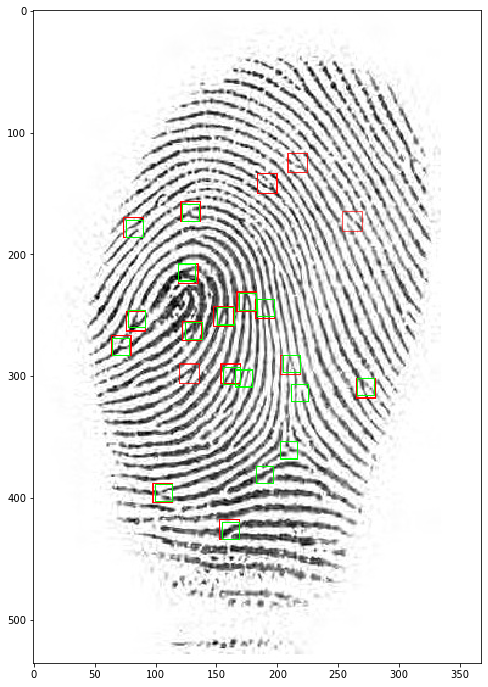

In [119]:
cls = DBSCAN(eps=4, min_samples=3, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
labels = cls.fit_predict(coord)
pts = np.array([np.average(coord[labels==value], axis=0, weights=prob[labels==value]) for value in np.unique(labels) if value != -1])
conf = np.array([(prob[labels==value]).mean(axis=0) for value in np.unique(labels) if value != -1])

image = cv2.imread(os.path.join(image_dir,train_set[i]+'.jpg'))/255.
image = add_points(image,pts, p=conf, rgb_color=(1,0,0))
image = add_points(image,points, p=1, rgb_color=(0,1,0), d=7)
print('Aggregated prediction')
plt.imshow(image)
plt.show()

In [75]:
from utils import match_points

#### On image from the internet

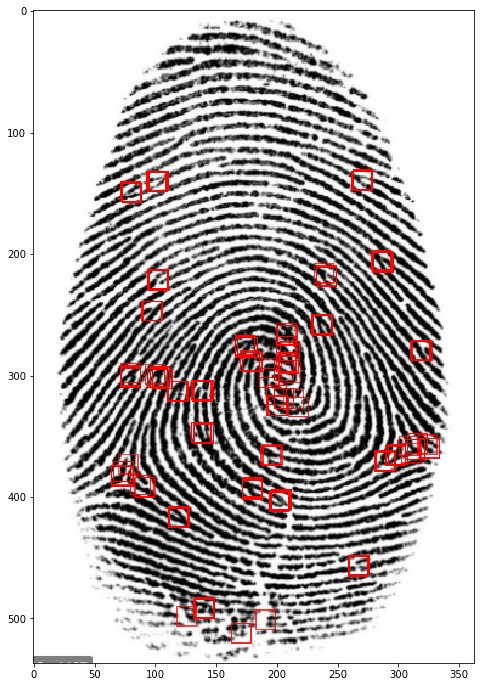

In [32]:
threshold = 0.7
image = cv2.imread('fingerprint.png', 2)/255.
# points =  pd.read_csv(os.path.join(point_dir,train_set[i]+'.txt'), delimiter="\t").values
coord, prob = model.predict(image,threshold)

image = cv2.imread('fingerprint.png')/255.
image = add_points(image,coord, p=prob)
plt.imshow(image)
plt.show()

Aggregated prediction


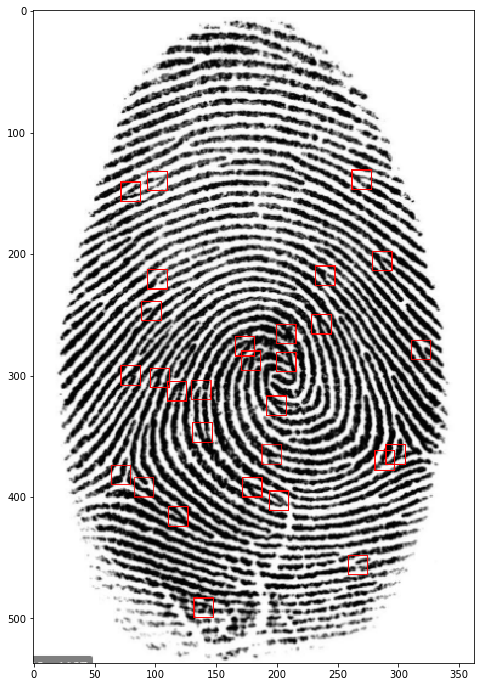

In [35]:
cls = DBSCAN(eps=3, min_samples=2, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
labels = cls.fit_predict(coord)
pts = np.array([np.average(coord[labels==value], axis=0, weights=prob[labels==value]) for value in np.unique(labels) if value != -1])
conf = np.array([(prob[labels==value]).mean(axis=0) for value in np.unique(labels) if value != -1])

image = cv2.imread('fingerprint.png')/255.
image = add_points(image,pts, p=conf, rgb_color=(1,0,0))
print('Aggregated prediction')
plt.imshow(image)
plt.show()

Aggregated prediction


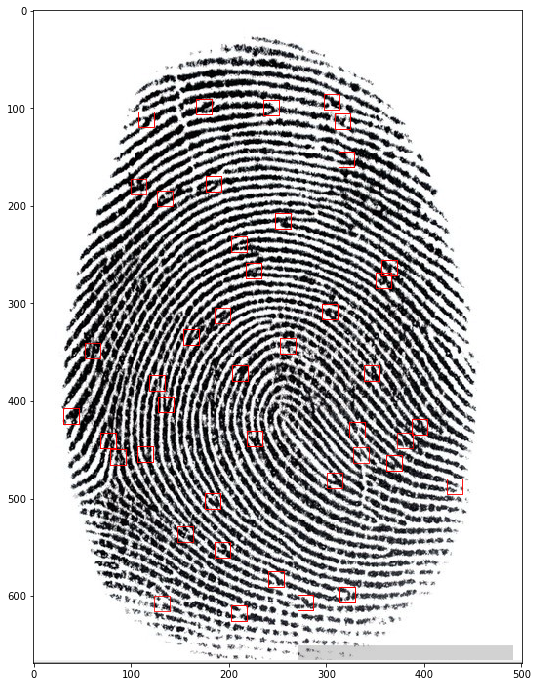

In [36]:
threshold = 0.7
image = cv2.imread('fingerprint2.png', 2)/255.
# points =  pd.read_csv(os.path.join(point_dir,train_set[i]+'.txt'), delimiter="\t").values
coord, prob = model.predict(image,threshold)

cls = DBSCAN(eps=3, min_samples=3, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
labels = cls.fit_predict(coord)
pts = np.array([np.average(coord[labels==value], axis=0, weights=prob[labels==value]) for value in np.unique(labels) if value != -1])
conf = np.array([(prob[labels==value]).mean(axis=0) for value in np.unique(labels) if value != -1])

image = cv2.imread('fingerprint2.png')/255.
image = add_points(image,pts, p=conf, rgb_color=(1,0,0))
print('Aggregated prediction')
plt.imshow(image)
plt.show()